<a href="https://colab.research.google.com/github/p15avgo/colab/blob/master/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf

In [0]:
!pip install -q -U tensorflow_hub

In [0]:
import tensorflow_hub as hub

from tensorflow.keras import layers

In [0]:
classifier_url = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4" #@param {type:"string"}

In [0]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [0]:
data_root = ('/content/drive/My Drive/Colab Notebooks/release_v0/images')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root),target_size=IMAGE_SHAPE)

Found 2023 images belonging to 35 classes.


In [0]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 35)


In [0]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [0]:
from keras.applications.imagenet_utils import decode_predictions

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4" #@param {type:"string"}

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [0]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1001)


In [0]:
feature_extractor_layer.trainable = False

In [0]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_3 (Dense)              (None, 35)                35070     
Total params: 55,910,343
Trainable params: 35,070
Non-trainable params: 55,875,273
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [0]:
predictions.shape

TensorShape([Dimension(32), Dimension(35)])

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [0]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=10,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/10
64/64 [==============================] - 45s 705ms/step - loss: 3.9450 - acc: 0.0938
Epoch 2/10
64/64 [==============================] - 26s 413ms/step - loss: 2.7633 - acc: 0.0625
Epoch 3/10
64/64 [==============================] - 26s 413ms/step - loss: 2.4030 - acc: 0.1875
Epoch 4/10
64/64 [==============================] - 26s 414ms/step - loss: 2.2020 - acc: 0.3438
Epoch 5/10
64/64 [==============================] - 27s 414ms/step - loss: 1.9998 - acc: 0.2812
Epoch 6/10
64/64 [==============================] - 27s 415ms/step - loss: 1.8742 - acc: 0.4688
Epoch 7/10
64/64 [==============================] - 27s 414ms/step - loss: 1.7934 - acc: 0.2812
Epoch 8/10
64/64 [==============================] - 26s 414ms/step - loss: 1.7813 - acc: 0.5000
Epoch 9/10
64/64 [==============================] - 26s 414ms/step - loss: 1.6235 - acc: 0.4062
Epoch 10/10
64/64 [==============================] - 27s 414ms/step - loss: 1.5678 - acc: 0.5938


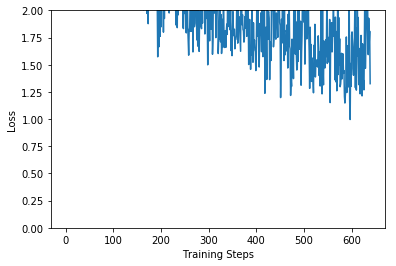

In [0]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

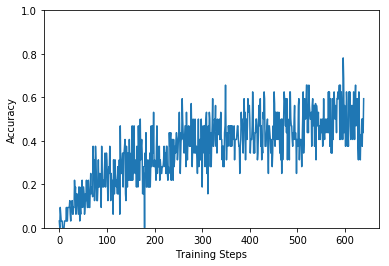

In [0]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [0]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['A1L', 'A2L', 'A3L', 'Adl', 'Ael', 'Fal', 'Fbl', 'Fcl', 'Fcl',
       'Fdl', 'Fel', 'Ffl', 'Fgl', 'Fhl', 'Fil', 'Fll', 'Fml', 'Gal',
       'Gbl', 'Gcl', 'Gdl', 'Ggl', 'Gzl', 'Nal', 'Nbl', 'Ncl', 'Ndl',
       'Nel', 'Nfl', 'Ngl', 'Nhl', 'Nil', 'Nll', 'Nml', 'New'],
      dtype='<U3')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [0]:
label_id = np.argmax(label_batch, axis=-1)

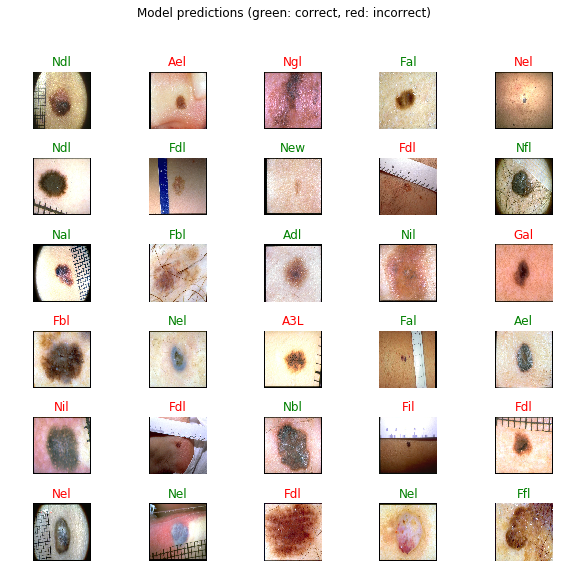

In [0]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")